In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from sif.samplers import EllipticalSliceSampler
from sif.models import GaussianProcess

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In this example, we'll be experimenting with periodicity to see if a Gaussian process can discover periodic behavior in an underlying function.

In [3]:
X = np.atleast_2d(np.linspace(0., 10., num=100)).T
X_pred = np.atleast_2d(np.linspace(0., 15., num=500)).T
y = np.random.normal(5. * X + 5. * np.sin(3.*X), .1)

We'll make use of a periodic kernel, which can be expressed as an exponentiated squared sin function. Such a kernel function is parametrized by its length scales, amplitude, periodicity, and multiplier.

In [4]:
class PeriodicKernel:
    def __init__(self, length_scale, amplitude, multiplier, periodicity):
        self.length_scale = length_scale
        self.amplitude = amplitude
        self.multiplier = multiplier
        self.periodicity = periodicity
    
    def cov(self, model_X, model_Y):
        length_scale = 1.
        nX = model_X / self.length_scale
        nY = model_Y / self.length_scale
        sq_dist = cdist(nX, nY, "sqeuclidean")
        dist = np.sqrt(sq_dist)
        return self.amplitude * np.exp(-sq_dist) * np.exp(-self.multiplier * np.sin(np.pi*dist / self.periodicity)**2)

We will again use the elliptical slice sampler to draw samples from the posterior over kernel parameters to account for epistemic uncertainty in the Gaussian process.

In [5]:
def log_likelihood_func(f):
    gp = GaussianProcess(PeriodicKernel(np.exp(f[:1]), np.exp(f[-4]), np.exp(f[-3]), np.exp(f[-2])), np.exp(f[-1]))
    gp.fit(X, y)
    return gp.log_likelihood

In [6]:
n_samples = 100
mean = np.zeros((5, ))
covariance = np.diag(np.ones((5, )) * 5.)

In [7]:
sampler = EllipticalSliceSampler(mean, covariance, log_likelihood_func)
samples = np.exp(sampler.sample(n_samples, burnin=5000))

In [8]:
func_samples = np.zeros((n_samples, X_pred.shape[0]))
for i in range(n_samples):
    gp = GaussianProcess(PeriodicKernel(samples[i, :1], samples[i, -4], samples[i, -3], samples[i, -2]), samples[i, -1])
    gp.fit(X, y)
    func_samples[i] = gp.sample(X_pred)

Now we visualize the sampled functions to see if the periodicity has been correctly identified.

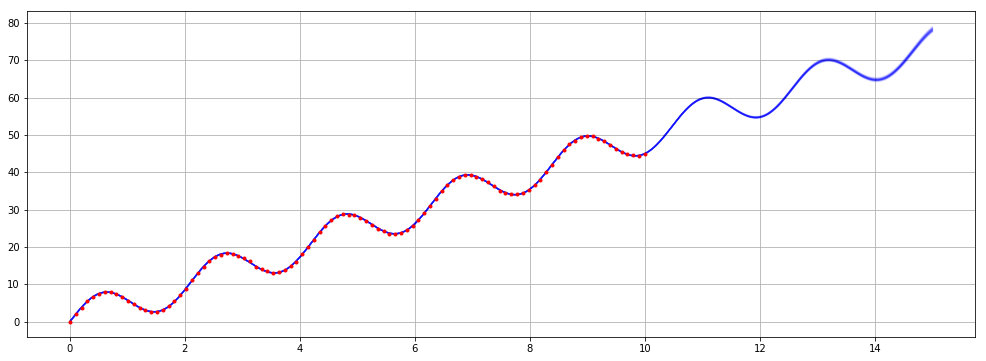

In [9]:
plt.figure(figsize=(17, 6))
for i in range(min(1000, n_samples)):
    plt.plot(X_pred.ravel(), func_samples[i], "b-", alpha=1. / 50)
plt.plot(X.ravel(), y.ravel(), "r.")
plt.grid()
plt.legend(fontsize=12)
plt.show()